In [1]:
#Script to determine and compare amino acid decomposition of the epitope
#@Author: Henriette Capel
#@Date: 22-03-2022

In [1]:
#Import modules
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
import ast
#from ABDB import database as db
#from scalop.predict import assign
import seaborn as sns

#Needed to analyse arpeggio
import Bio.PDB
from Bio.Data.IUPACData import protein_letters_3to1
import re

from statsmodels.stats.weightstats import ztest as ztest
import dabest

#%load_ext nb_black

In [2]:
plt.rcParams['figure.dpi'] = 1200

In [3]:
#Constants
binning_scheme = {
  'D':'F','E':'F','H':'E','K':'E','R':'E',
  'I':'A','L':'A','M':'C','P':'A','V':'A',
  'N':'G','Q':'G','C':'C','S':'D','T':'D',
  'A':'A','G':'A','F':'B','W':'B','Y':'B'
}

colour_palette_aa_group = {'A': 'lightgreen',
                          'B': 'mediumpurple',
                          'C': 'yellow',
                          'D': 'orange',
                          'E': 'blue',
                          'F': 'tomato',
                          'G': 'tab:cyan'}

colour_palette_aa_group_2 = {'A': 'green',
                          'B': 'purple',
                          'C': 'gold',
                          'D': 'darkorange',
                          'E': 'darkblue',
                          'F': 'red',
                          'G': 'darkcyan'}


In [4]:
#Functions
def read_dataset(filename_ds):
    
    df = pd.read_csv(filename_ds, converters={i: str for i in range(100)})
    
    for colname in df.columns.values.tolist():
        try:
            df[colname] = [ast.literal_eval(d) for d in df[colname]]
        except:
            pass

    return df

def epitope_decomposition(df, binning_scheme):
    df_selection = df[['pdb', 'antigen_chain', 'antibody_chain', 'epitope_MWV_dict']]
    df_epi_group = add_group_seq_to_df(df_selection, binning_scheme, 'epitope_group_seq')
    df_epi_fraction_per_sequence = add_frac_occurence_to_df(df_epi_group, df_epi_group.epitope_group_seq, binning_scheme, 'epitope_frac_occurence')
    df_frac_occurence_per_aagroup = store_fraction_occurence_aa_group(df_epi_fraction_per_sequence.epitope_frac_occurence, binning_scheme)
    
    return df_epi_fraction_per_sequence, df_frac_occurence_per_aagroup
    

def create_format_group_dict(binning_scheme):
    #Create format for group fraction dictionary
    dict_aa_group_format = {}
    for aa_group in sorted(list(set(binning_scheme.values()))):
        dict_aa_group_format[aa_group] = []
    return dict_aa_group_format

def store_fraction_occurence_aa_group(input_column, binning_scheme):
    dict_group_fractions = create_format_group_dict(binning_scheme)
    for dict_occurence in input_column:
        for aa_group in dict_group_fractions.keys():
            dict_group_fractions[aa_group].append(dict_occurence[aa_group])
    df_frac_occurence = pd.DataFrame(dict_group_fractions)
    
    return df_frac_occurence
    

def add_frac_occurence_to_df(df, info_column, binning_scheme, new_colname):
    list_dicts_group_fraction = []
    epiope_group_seq_column = info_column
    for epitope in epiope_group_seq_column:
        dict_group_fraction = {}
        counter = Counter(epitope)
        length_epitope = len(epitope)
        
        #Fill in empty dictionary
        for aa_group in sorted(list(set(binning_scheme.values()))):
            try:
                dict_group_fraction[aa_group] = counter[aa_group]/length_epitope
            except:
                dict_group_fraction[aa_group] = 0.0
        list_dicts_group_fraction.append(dict_group_fraction)
    
    df[new_colname] = list_dicts_group_fraction
    
    return df

def add_group_seq_to_df(df, binning_scheme, name_new_column):
    epiope_seq_column = df.epitope_MWV_dict
    
    list_seq_group = []
    for dict_epi in epiope_seq_column:
        seq_epi = ""
        
        #Select the epitope based on both the heavy and light chain for full length antibodies
        if any(isinstance(i,dict) for i in dict_epi.values()): #check if dictionary is nested; than dealing with full length antibody.
            for chain in dict_epi.keys():
                if len(chain) == 2:
                    dict_epi_res = dict_epi[chain]
                    
        else: #Single domain antibody
            dict_epi_res = dict_epi
            
        for position in dict_epi_res.keys():
            seq_epi += dict_epi_res[position]
        seq_group = determine_aa_group(seq_epi, binning_scheme)
        list_seq_group.append(seq_group)
    
    df[name_new_column] = list_seq_group
    
    return df

def determine_aa_group(sequence, binning_scheme):
    aa_group_seq = ''
    for residue in sequence:
        aa_group_seq += binning_scheme[residue]
    return aa_group_seq

def df_clustermap_info(df_epi_fraction_per_sequence):
    df_epi_fraction_per_sequence['interaction_id'] = df_epi_fraction_per_sequence[['pdb', 'antigen_chain', 'antibody_chain']].agg('_'.join, axis=1)
    
    df_new = pd.concat([df_epi_fraction_per_sequence, df_epi_fraction_per_sequence["epitope_frac_occurence"].apply(pd.Series)], axis=1)
    
    df_new = df_new.drop(['pdb', 'antigen_chain', 'antibody_chain', 'epitope_MWV_dict', 'epitope_group_seq', 'epitope_frac_occurence'], axis =1)

    return df_new

def df_clustermap_twotypes_info(df_nb, df_fv):
    df_nb = df_nb.copy(deep=True) #Needed to prevent changing original dataframes
    df_fv = df_fv.copy(deep=True)
    df_nb['antibody_type'] = "single_domain"
    df_fv['antibody_type'] = "full_length"
    df_concat = pd.concat([df_nb, df_fv])
    
    return df_concat

def perform_bootstrap(n_sample, interaction_sizes):
    df = pd.DataFrame([np.random.choice(interaction_sizes[k],n_sample,replace=False) for k in interaction_sizes]).T
    df.columns = [k for k in interaction_sizes]
    x = dabest.load(df, idx=(list(interaction_sizes.keys())[0],list(interaction_sizes.keys())[1]))
    print(x.mean_diff)

def plot_epitope_decomposition(df, title, colour_palette):
    binwidth = 0.05

    for i in df.columns:
        #Weights to make sure all barst together per aa group will add up to 1
        plt.hist(df[i], alpha=0.5, bins=np.arange(0.0, 1.0+binwidth, binwidth), label= i, color = colour_palette[i], weights=np.zeros_like(df[i]) + 1. / df[i].size)
        
    plt.title(f"{title}")
    plt.xlabel("Proportion of occurrence in epitope")
    plt.ylabel("Normalised frequency")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    
def plot_epitope_decomposition_stacked(df, title, colour_palette, xlabel):
    binwidth = 0.05
    
    data = []
    labels = []
    colours = []
    weights = []

    for i in df.columns:
        data.append(df[i])
        labels.append(f"{i} ({round(df[i].mean(),2)}, {round(df[i].std(),2)})")
        colours.append(colour_palette[i])
        weights.append(np.zeros_like(df[i]) + 1. / df[i].size)
    
    print(labels)
    new_labels = ['Aliphatic', 'Aromatic', 'Sulfur', 'Hydroxyl', 'Basic', 'Acidic', 'Amine']
    plt.hist(data, alpha=0.5, bins=np.arange(0.0, 1.0+binwidth, binwidth), label= new_labels, color = colours, weights=weights, stacked=True)    
        
    #plt.title(f"{title}")
    plt.xlabel("Proportion of amino acid class in " + xlabel + " epitope")
    plt.ylabel("Normalised frequency")
    plt.legend(loc='upper right')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    # plt.savefig(f'aa_decomposition_epitope_arpegio_{title}.png', bbox_inches='tight')
    
def plot_epitope_distribution_difference_per_group(df1, df2, ds_1, ds_2, colour_palette1, colour_palette2):
    binwidth = 0.05
    for i in df1.columns:
        if type(colour_palette1) is dict:
            colour1= colour_palette1[i]
            colour2= colour_palette2[i]
        else: 
            colour1 = colour_palette1
            colour2= colour_palette2
        
        #perform statistical testing
        print(f"ztest result: {ztest(df1[i], df2[i])}")
        dict_info = {ds_1: df1[i], ds_2: df2[i]}
        perform_bootstrap(300, dict_info)
        
        plt.hist(df1[i], alpha=0.5, bins = np.arange(0.0, 1.0+binwidth, binwidth), label= ds_1, color = colour1, weights=np.zeros_like(df1[i]) + 1. / df1[i].size, stacked = True)
        plt.hist(df2[i], alpha=0.5, bins = np.arange(0.0, 1.0+binwidth, binwidth), label= ds_2, color = colour2, weights=np.zeros_like(df2[i]) + 1. / df2[i].size, stacked = True)
        
        plt.title(f"Amino acid group: {i}")
        plt.xlabel("Proportion of occurrence in epitope")
        plt.ylabel("Normalised frequency")
        plt.legend()
        plt.show()

def plot_cluster(df_cluster_info: pd.DataFrame, two_types: bool = False):
    df_cluster_info = df_cluster_info.set_index('interaction_id')
    #sns.light_palette("seagreen", as_cmap=True)
    
    if two_types == True:
        antibody_type = df_cluster_info.pop("antibody_type")
        lut = dict(zip(antibody_type.unique(), ['royalblue', 'lightcoral']))
        row_colors = antibody_type.map(lut)
        g = sns.clustermap(df_cluster_info, row_colors=row_colors)
    else:
        g = sns.clustermap(df_cluster_info)
        

In [5]:
#Single domain antibodies
ds_name_nb = "/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_nb_filtered.csv"
df_nb = read_dataset(ds_name_nb)
df_epi_fraction_per_sequence_nb, df_frac_occurence_per_aagroup_nb = epitope_decomposition(df_nb, binning_scheme)

/Users/gemmagordon/opt/anaconda3/envs/rotation_2_local/lib/python3.6/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gemmagordon/opt/anaconda3/envs/rotation_2_local/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


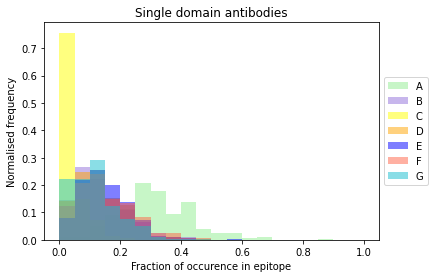

In [5]:
plot_epitope_decomposition(df_frac_occurence_per_aagroup_nb, "Single domain antibodies", colour_palette_aa_group)

['A (0.31, 0.12)', 'B (0.13, 0.09)', 'C (0.03, 0.04)', 'D (0.13, 0.08)', 'E (0.15, 0.08)', 'F (0.15, 0.09)', 'G (0.11, 0.08)']


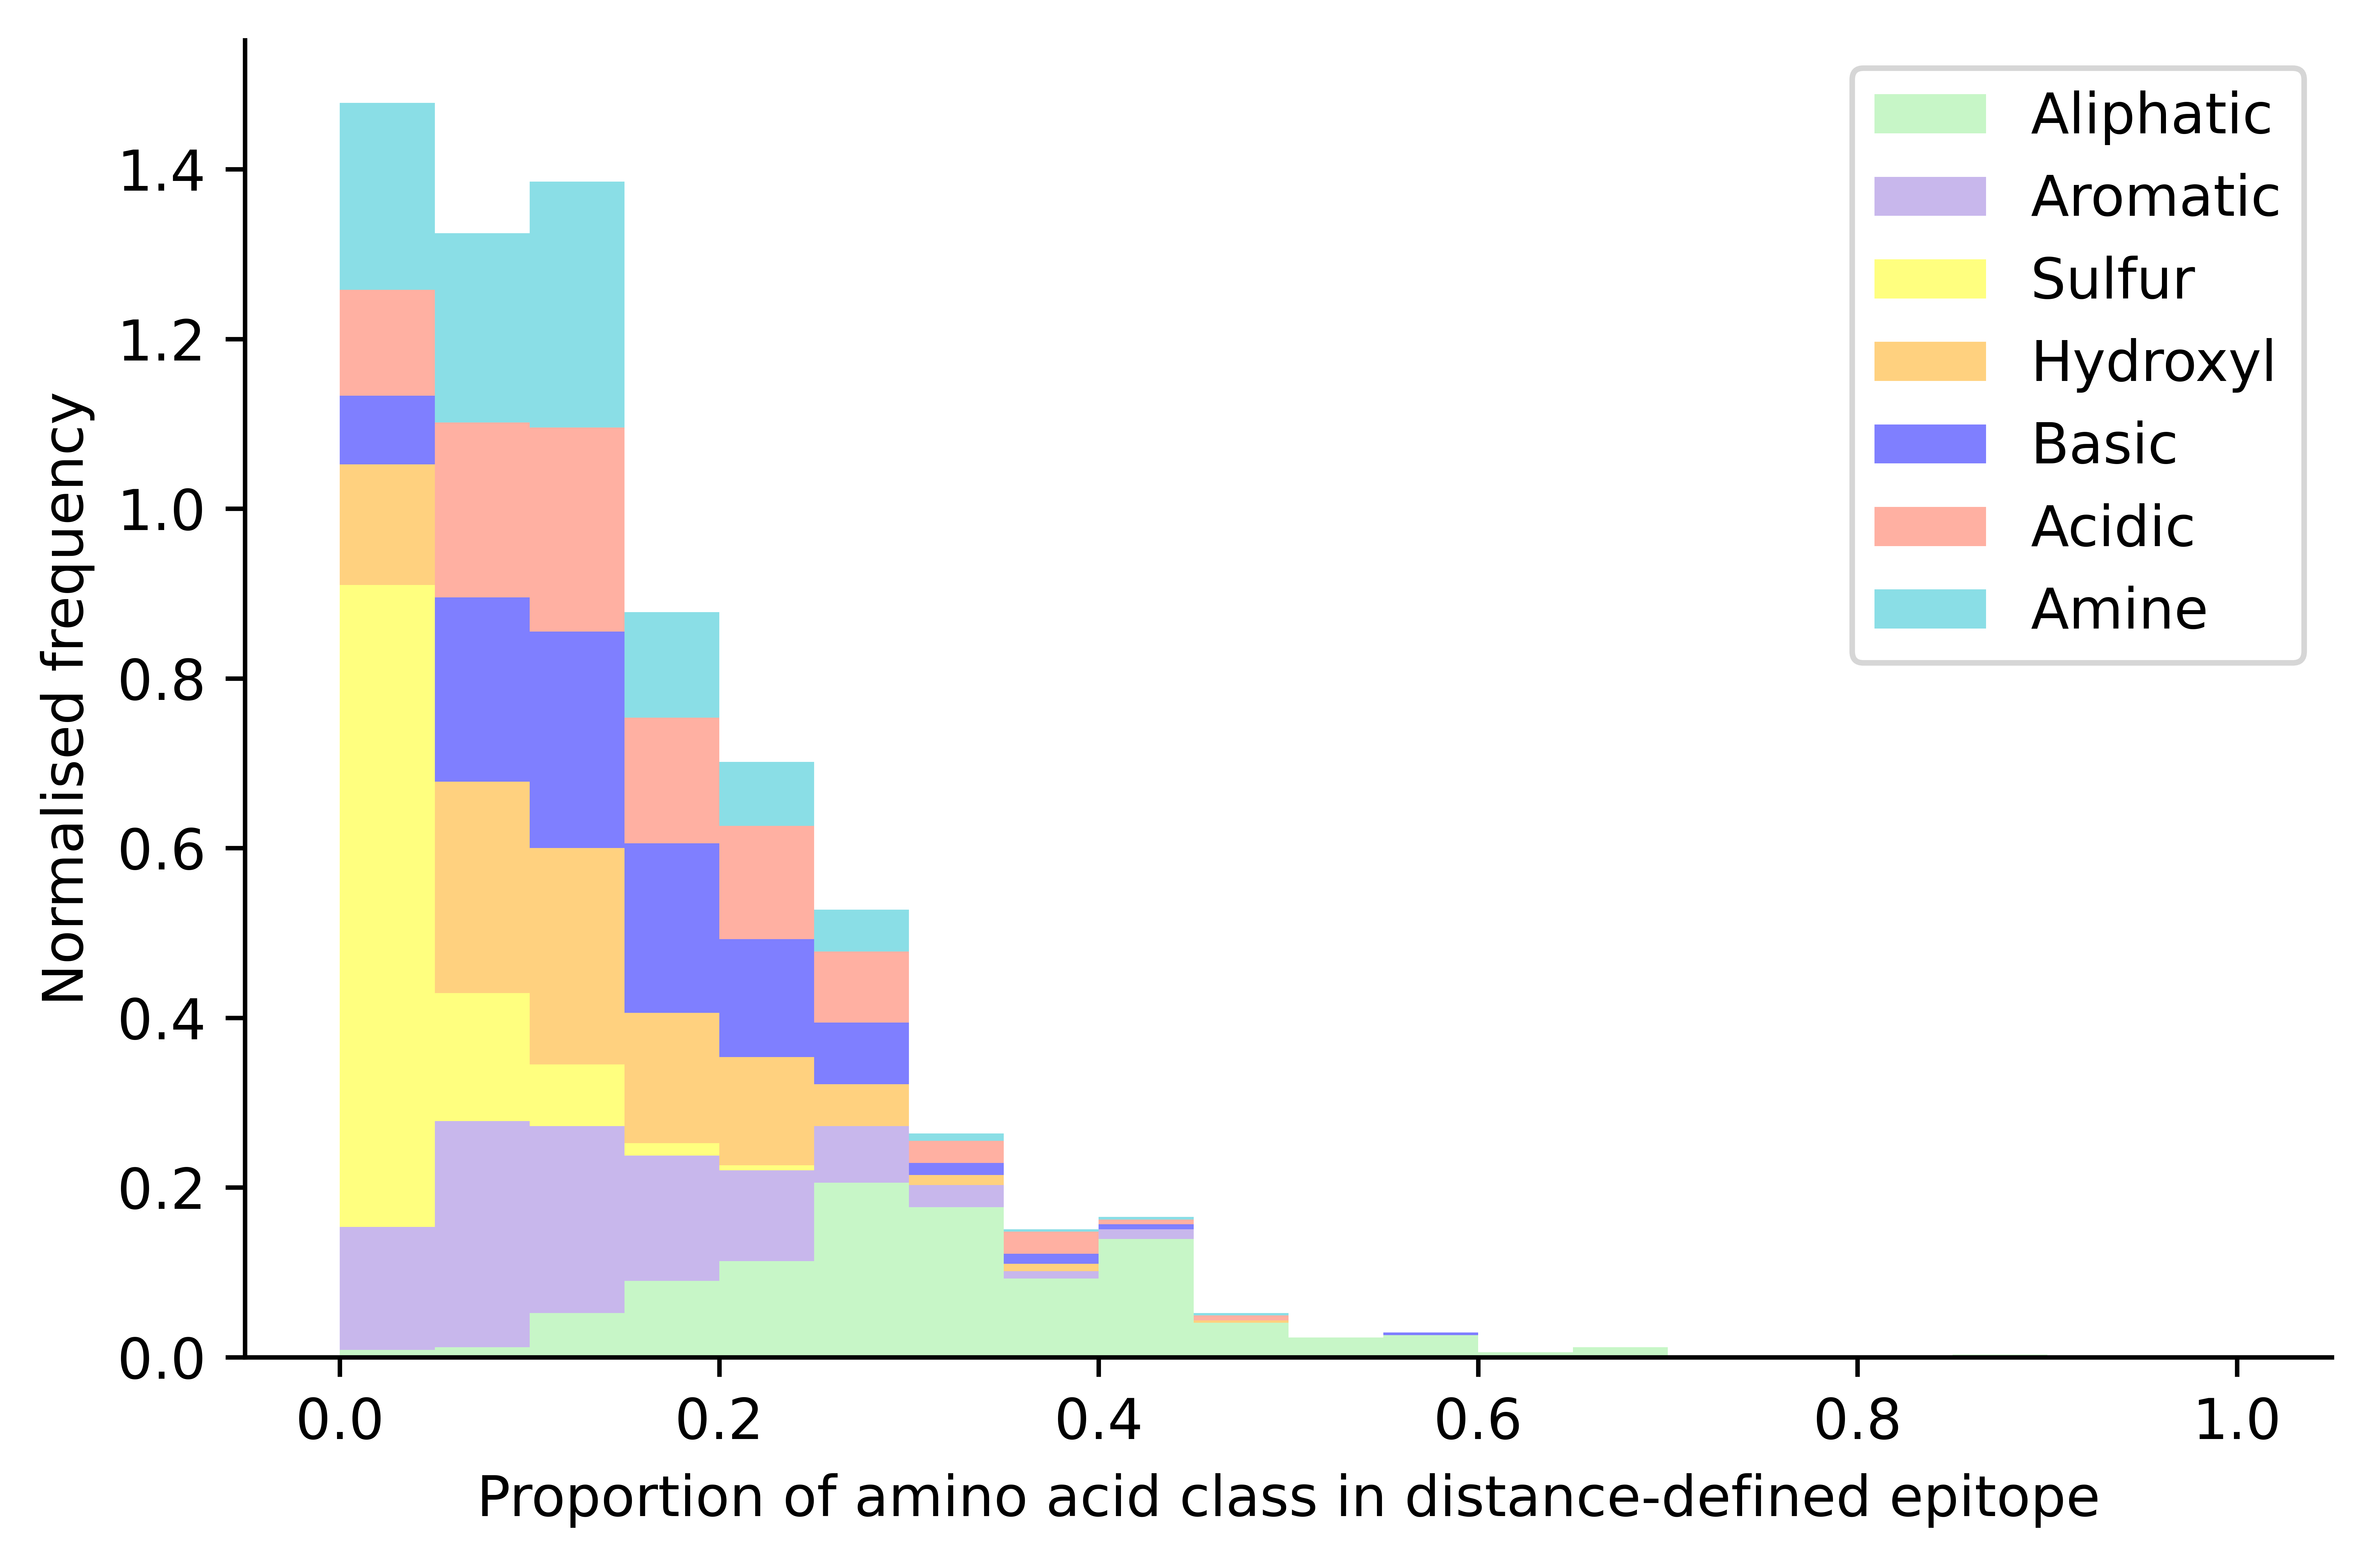

In [6]:
#Plot stacked
plot_epitope_decomposition_stacked(df_frac_occurence_per_aagroup_nb, "sdAb", colour_palette_aa_group, 'distance-defined')

In [7]:
#Full length antibodies
ds_name_fv = "/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_fv_filtered.csv"
df_fv = read_dataset(ds_name_fv)
df_epi_fraction_per_sequence_fv, df_frac_occurence_per_aagroup_fv = epitope_decomposition(df_fv, binning_scheme)

/Users/gemmagordon/opt/anaconda3/envs/rotation_2_local/lib/python3.6/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gemmagordon/opt/anaconda3/envs/rotation_2_local/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
# plot_epitope_decomposition(df_frac_occurence_per_aagroup_fv, "Full length antibodies", colour_palette_aa_group)

['A (0.31, 0.11)', 'B (0.11, 0.09)', 'C (0.03, 0.05)', 'D (0.13, 0.08)', 'E (0.17, 0.09)', 'F (0.13, 0.08)', 'G (0.12, 0.08)']


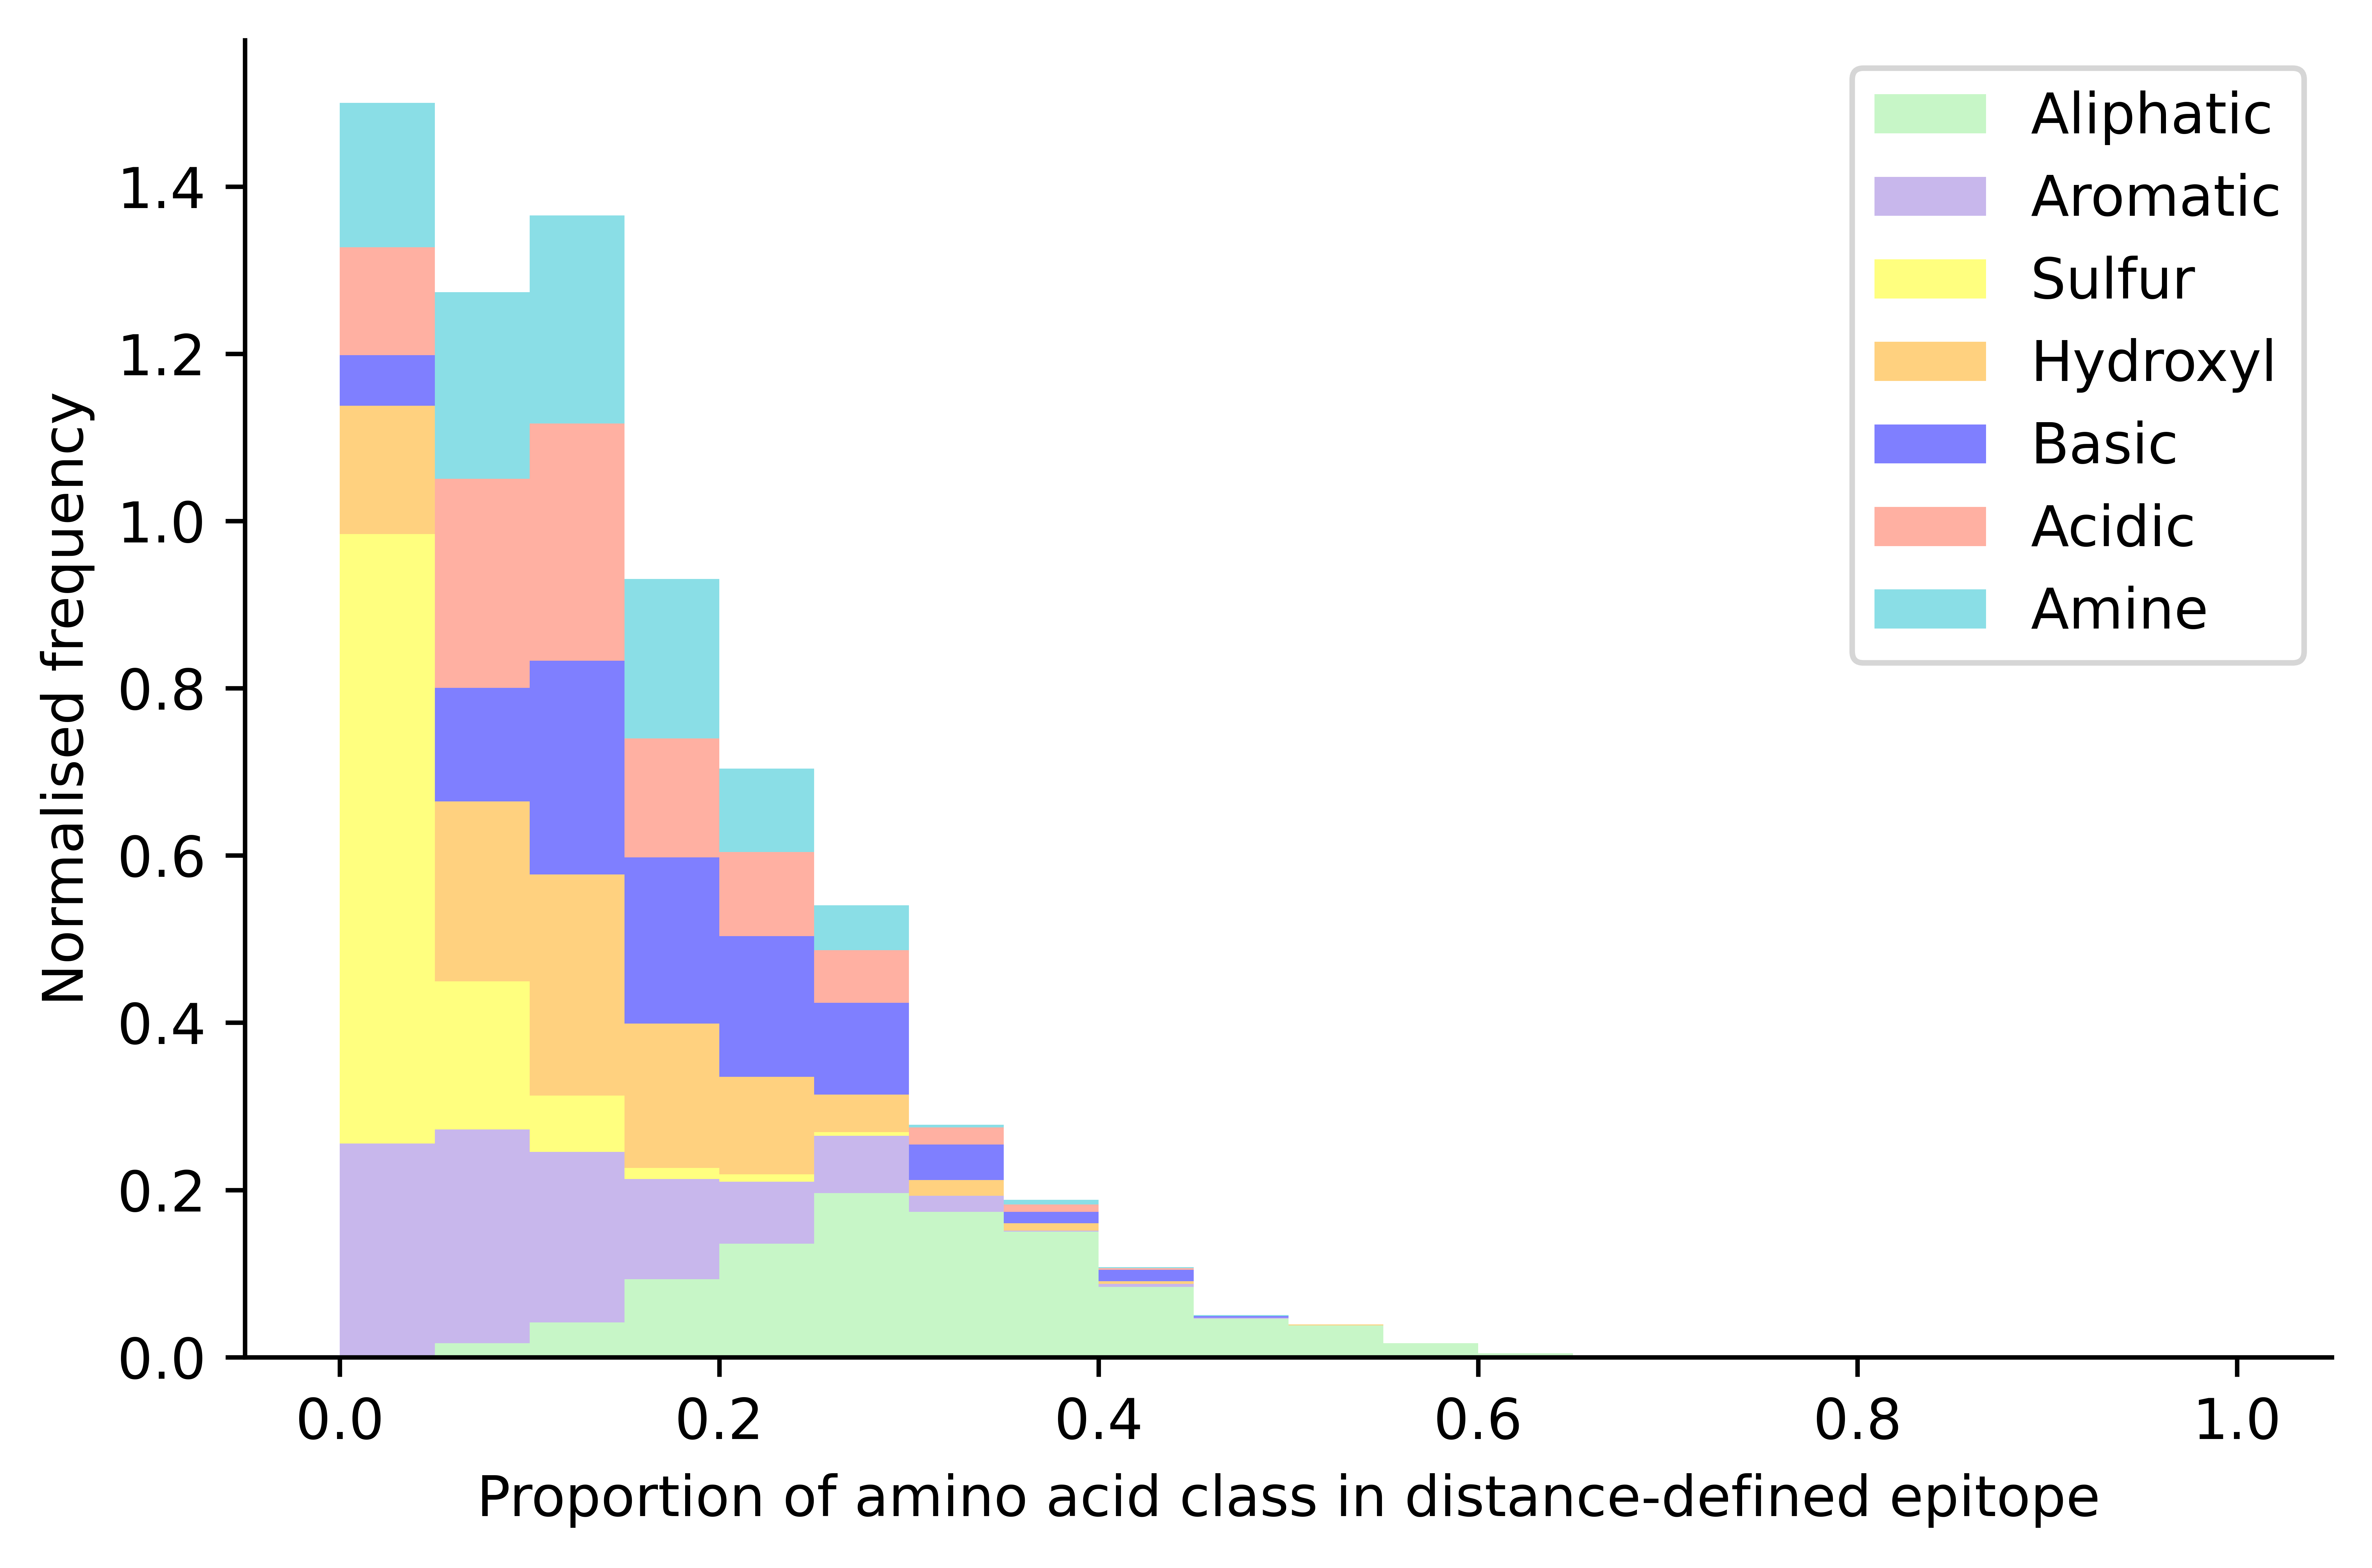

In [8]:
plot_epitope_decomposition_stacked(df_frac_occurence_per_aagroup_fv, "flAb", colour_palette_aa_group, 'distance-defined')

ztest result: (0.8134354764393955, 0.4159684261759622)
DABEST v0.3.1
             
Good afternoon!
The current time is Sun Dec 11 14:37:19 2022.

The unpaired mean difference between Single domain and Full length is -0.00288 [95%CI -0.0224, 0.0156].
The p-value of the two-sided permutation t-test is 0.759. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


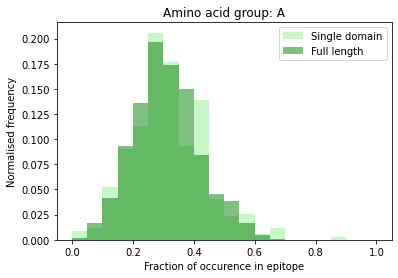

ztest result: (3.3133547365508225, 0.0009218397894029111)
DABEST v0.3.1
             
Good afternoon!
The current time is Sun Dec 11 14:37:20 2022.

The unpaired mean difference between Single domain and Full length is -0.0151 [95%CI -0.0291, 1.08e-05].
The p-value of the two-sided permutation t-test is 0.0376. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


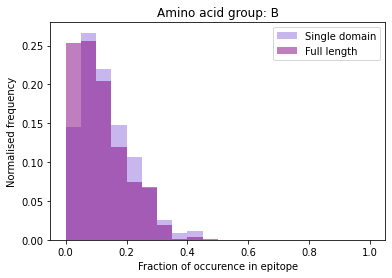

ztest result: (-1.0114159810737104, 0.3118173755001846)
DABEST v0.3.1
             
Good afternoon!
The current time is Sun Dec 11 14:37:21 2022.

The unpaired mean difference between Single domain and Full length is 0.00298 [95%CI -0.00402, 0.0102].
The p-value of the two-sided permutation t-test is 0.418. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


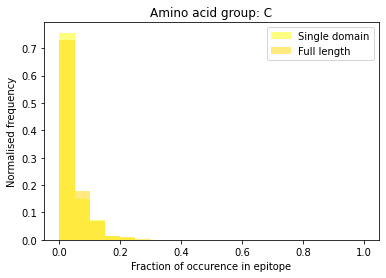

ztest result: (-0.3931122468854942, 0.6942365790809788)
DABEST v0.3.1
             
Good afternoon!
The current time is Sun Dec 11 14:37:23 2022.

The unpaired mean difference between Single domain and Full length is 0.00329 [95%CI -0.00981, 0.0161].
The p-value of the two-sided permutation t-test is 0.627. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


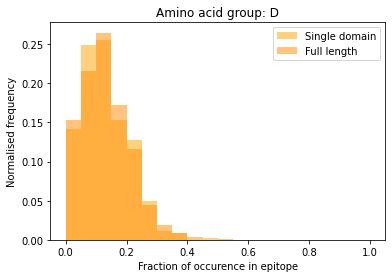

ztest result: (-4.4171698132048, 1.000016650476243e-05)
DABEST v0.3.1
             
Good afternoon!
The current time is Sun Dec 11 14:37:24 2022.

The unpaired mean difference between Single domain and Full length is 0.0209 [95%CI 0.00799, 0.0339].
The p-value of the two-sided permutation t-test is 0.002. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


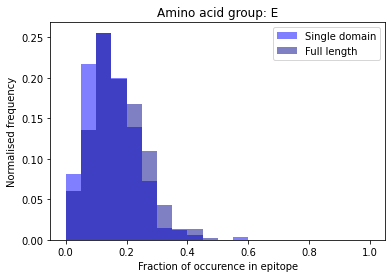

ztest result: (3.1923929447813895, 0.001410992379171491)
DABEST v0.3.1
             
Good afternoon!
The current time is Sun Dec 11 14:37:25 2022.

The unpaired mean difference between Single domain and Full length is -0.0211 [95%CI -0.0347, -0.00748].
The p-value of the two-sided permutation t-test is 0.0032. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


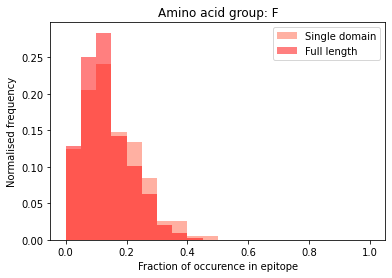

ztest result: (-2.4470492019008185, 0.014403117560227427)
DABEST v0.3.1
             
Good afternoon!
The current time is Sun Dec 11 14:37:26 2022.

The unpaired mean difference between Single domain and Full length is 0.0155 [95%CI 0.00272, 0.0276].
The p-value of the two-sided permutation t-test is 0.0124. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


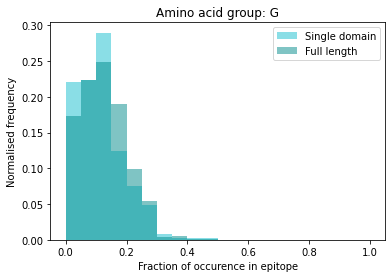

In [35]:
#Plot difference decomposition between single domain and full length per amino acid group 
plot_epitope_distribution_difference_per_group(df_frac_occurence_per_aagroup_nb, df_frac_occurence_per_aagroup_fv, "Single domain", "Full length", colour_palette_aa_group, colour_palette_aa_group_2)

In [36]:
#Plot difference decomposition between single domain and full length per amino acid group with sdab and flab colors
# plot_epitope_distribution_difference_per_group(df_frac_occurence_per_aagroup_nb, df_frac_occurence_per_aagroup_fv, "Single domain", "Full length", 'royalblue', 'lightcoral')

In [37]:
#Cluster
df_fractions_per_interaction_nb = df_clustermap_info(df_epi_fraction_per_sequence_nb)
df_fractions_per_interaction_fv = df_clustermap_info(df_epi_fraction_per_sequence_fv)
df_fractions_per_interaction_nb_fv = df_clustermap_twotypes_info(df_fractions_per_interaction_nb, df_fractions_per_interaction_fv)

/Users/gemmagordon/opt/anaconda3/envs/rotation_2_local/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


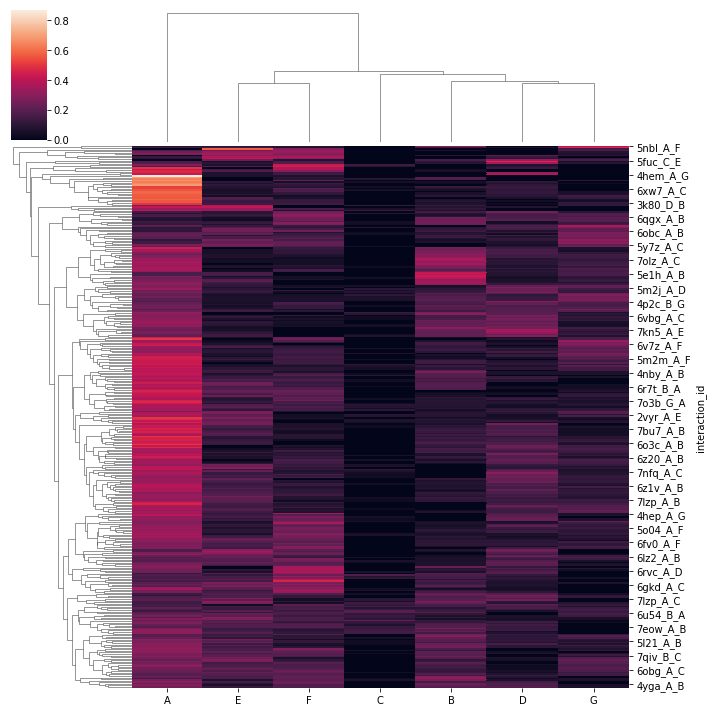

In [38]:
plot_cluster(df_fractions_per_interaction_nb)

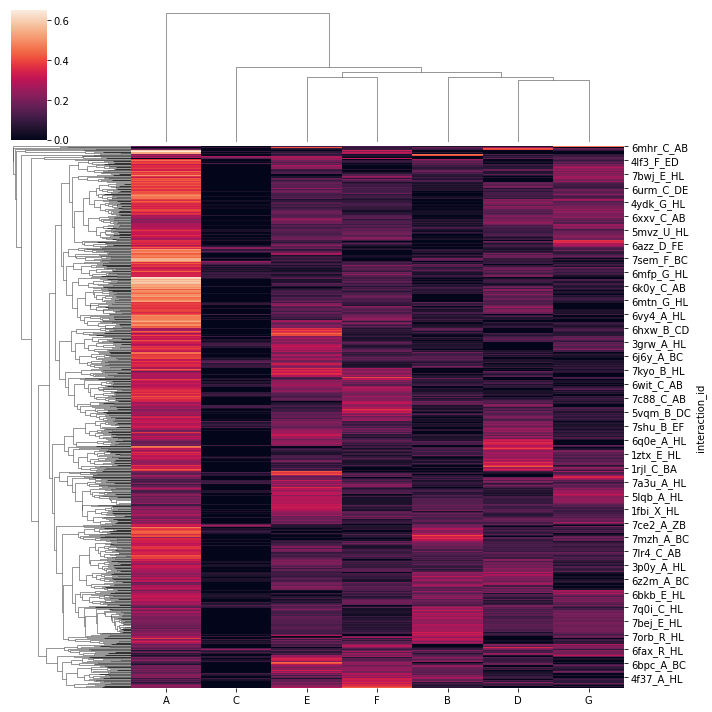

In [39]:
plot_cluster(df_fractions_per_interaction_fv)

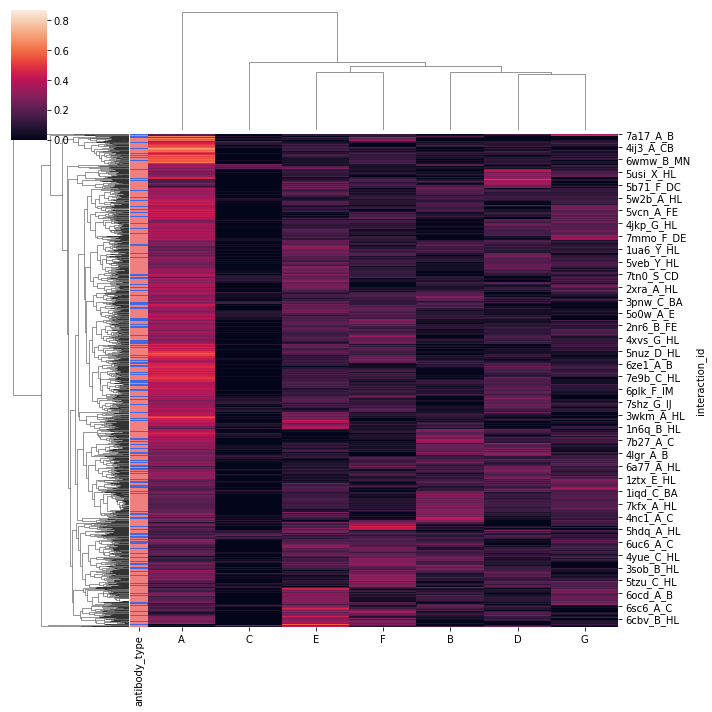

In [40]:
plot_cluster(df_fractions_per_interaction_nb_fv, two_types=True)

In [41]:
######## AFTER ARPEGGIO ########

In [9]:
#Single domain antibodies
ds_name_arp_int_nb = "/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_nb_arpeggio_interactions.csv"
df_arp_int_nb = read_dataset(ds_name_arp_int_nb)
df_epi_fraction_per_sequence_arp_nb, df_frac_occurence_per_aagroup_arp_nb=epitope_decomposition(df_arp_int_nb, binning_scheme)

/Users/gemmagordon/opt/anaconda3/envs/rotation_2_local/lib/python3.6/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gemmagordon/opt/anaconda3/envs/rotation_2_local/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['A (0.3, 0.13)', 'B (0.14, 0.1)', 'C (0.03, 0.05)', 'D (0.12, 0.1)', 'E (0.14, 0.1)', 'F (0.16, 0.11)', 'G (0.11, 0.09)']


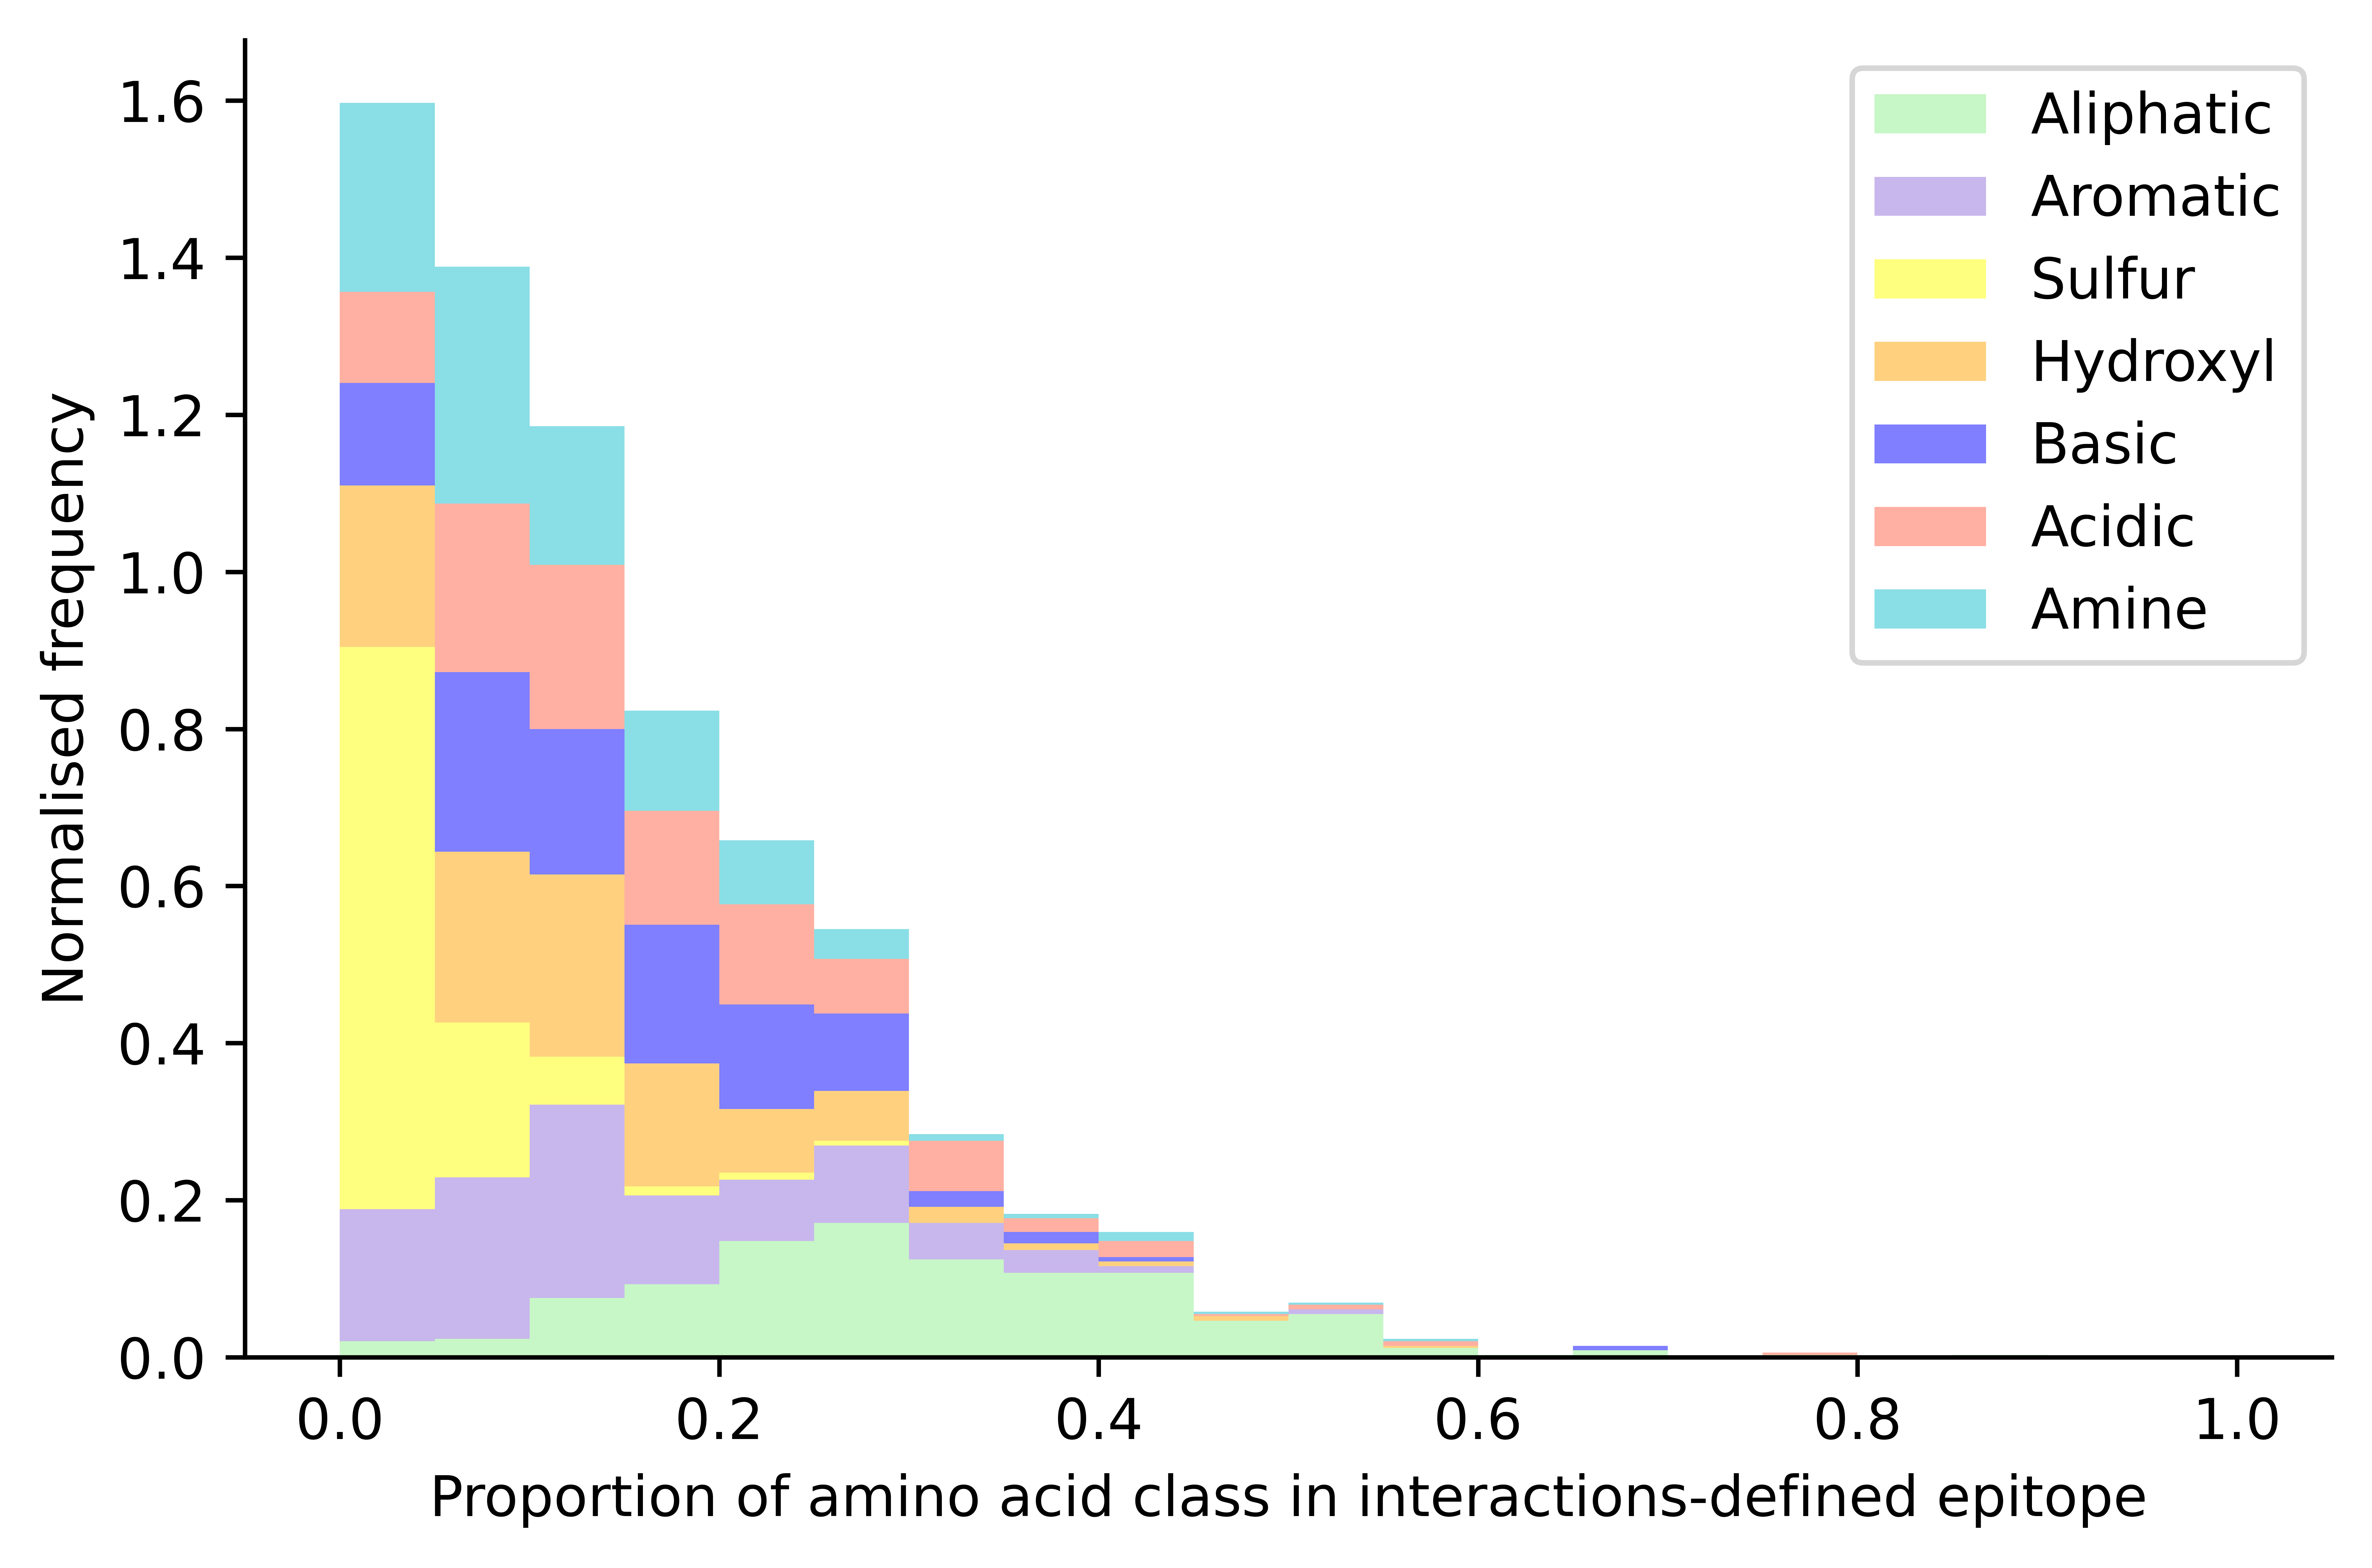

In [10]:
#Plot stacked
plot_epitope_decomposition_stacked(df_frac_occurence_per_aagroup_arp_nb, "Single domain antibodies", colour_palette_aa_group, 'interactions-defined')

In [11]:
#Full length antibodies
ds_name_arp_int_fv = "/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_fv_arpeggio_interactions.csv"
df_arp_int_fv = read_dataset(ds_name_arp_int_fv)
df_epi_fraction_per_sequence_arp_fv, df_frac_occurence_per_aagroup_arp_fv=epitope_decomposition(df_arp_int_fv, binning_scheme)

/Users/gemmagordon/opt/anaconda3/envs/rotation_2_local/lib/python3.6/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gemmagordon/opt/anaconda3/envs/rotation_2_local/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['A (0.3, 0.13)', 'B (0.12, 0.1)', 'C (0.03, 0.05)', 'D (0.12, 0.09)', 'E (0.18, 0.11)', 'F (0.14, 0.09)', 'G (0.12, 0.09)']


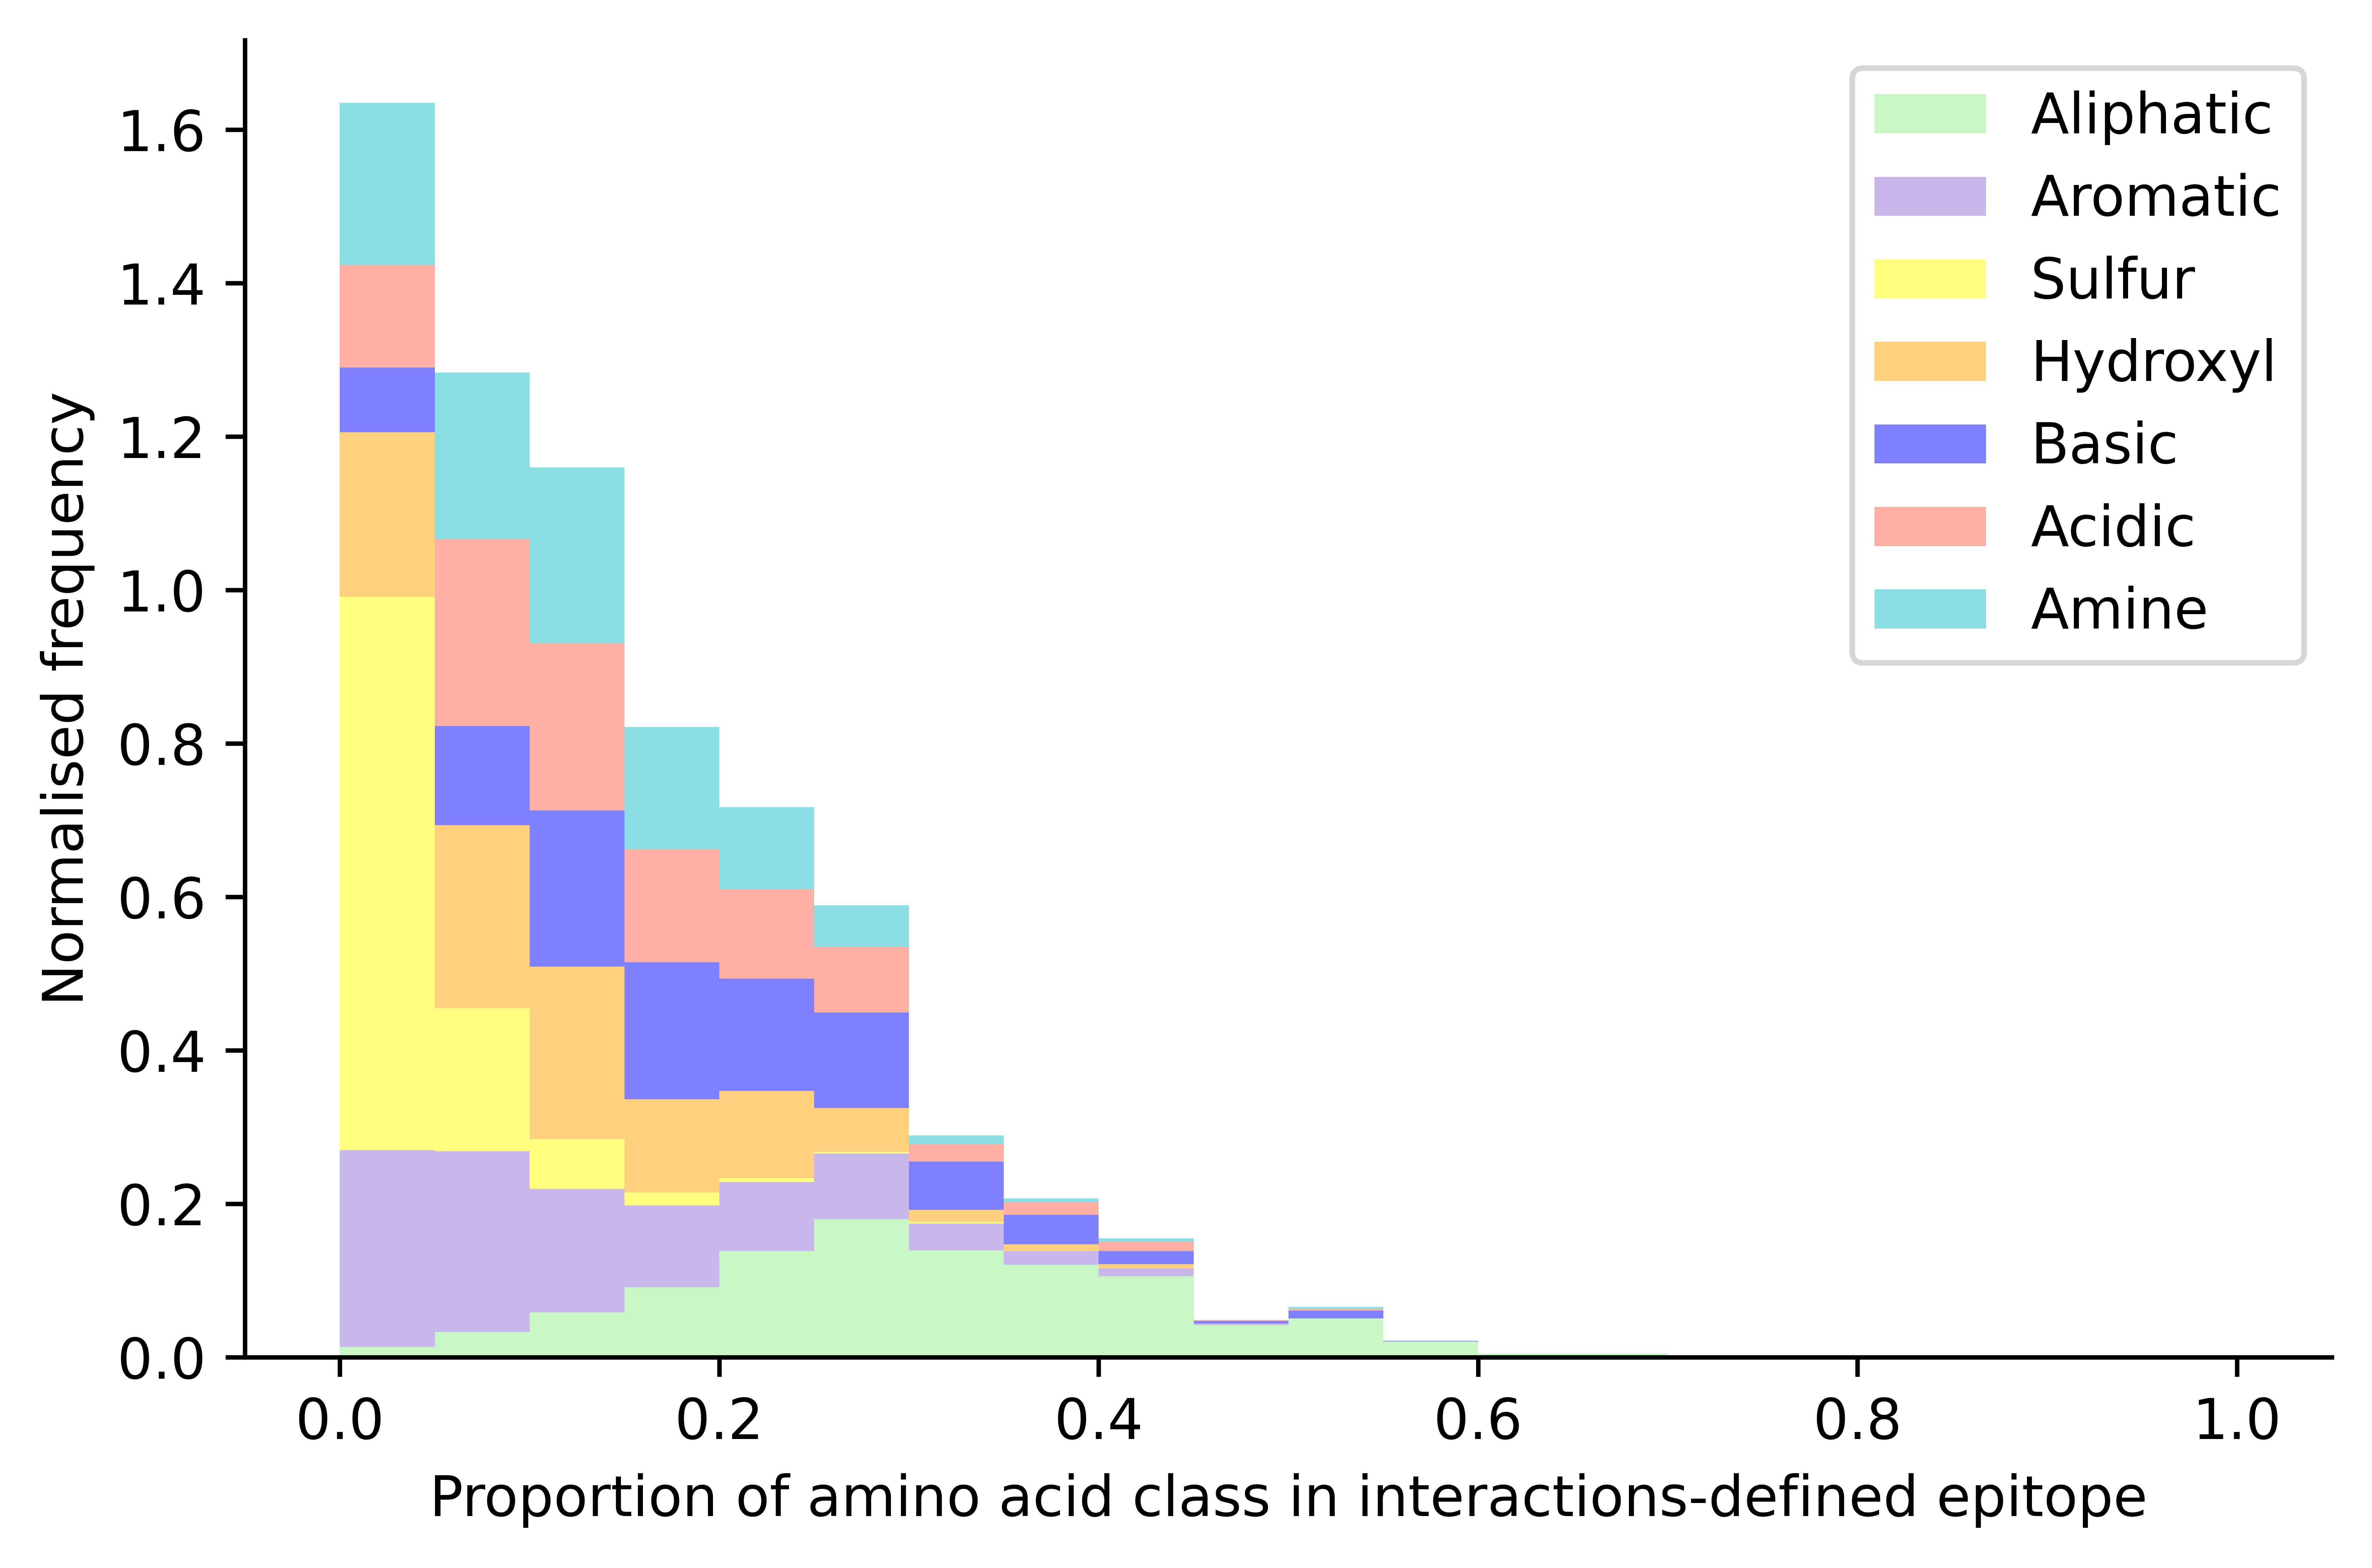

In [12]:
#Plot stacked
plot_epitope_decomposition_stacked(df_frac_occurence_per_aagroup_arp_fv, "Full length antibodies", colour_palette_aa_group, 'interactions-defined')

ztest result: (-0.13505170635249025, 0.8925709930084629)
DABEST v0.3.1
             
Good afternoon!
The current time is Thu Jun  9 14:40:32 2022.

The unpaired mean difference between Single domain and Full length is 0.0171 [95%CI -0.0027, 0.0386].
The p-value of the two-sided permutation t-test is 0.11. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


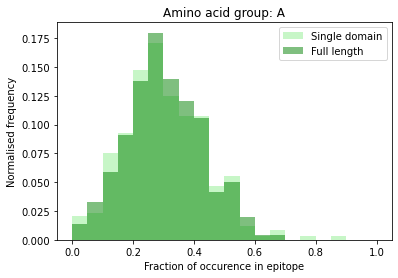

ztest result: (3.035522661548674, 0.002401191782083355)
DABEST v0.3.1
             
Good afternoon!
The current time is Thu Jun  9 14:40:33 2022.

The unpaired mean difference between Single domain and Full length is -0.0192 [95%CI -0.0378, -0.00214].
The p-value of the two-sided permutation t-test is 0.0272. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


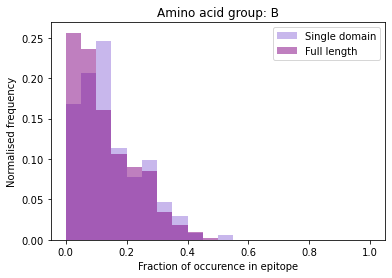

ztest result: (-0.01718977003262415, 0.9862852233163085)
DABEST v0.3.1
             
Good afternoon!
The current time is Thu Jun  9 14:40:34 2022.

The unpaired mean difference between Single domain and Full length is 0.000341 [95%CI -0.00751, 0.00796].
The p-value of the two-sided permutation t-test is 0.93. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


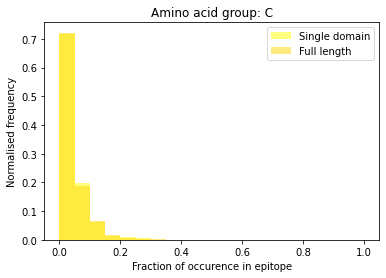

ztest result: (1.1482147611867255, 0.25087991702498724)
DABEST v0.3.1
             
Good afternoon!
The current time is Thu Jun  9 14:40:35 2022.

The unpaired mean difference between Single domain and Full length is -0.00792 [95%CI -0.0236, 0.00665].
The p-value of the two-sided permutation t-test is 0.308. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


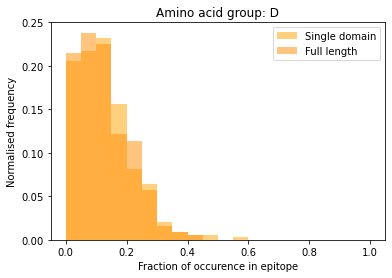

ztest result: (-5.282926934852396, 1.2713610632140604e-07)
DABEST v0.3.1
             
Good afternoon!
The current time is Thu Jun  9 14:40:36 2022.

The unpaired mean difference between Single domain and Full length is 0.025 [95%CI 0.00892, 0.0409].
The p-value of the two-sided permutation t-test is 0.0014. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


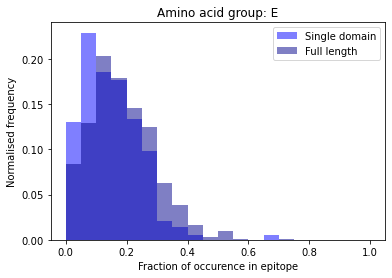

ztest result: (2.973390131354221, 0.002945298292105697)
DABEST v0.3.1
             
Good afternoon!
The current time is Thu Jun  9 14:40:37 2022.

The unpaired mean difference between Single domain and Full length is -0.0163 [95%CI -0.0337, -0.000387].
The p-value of the two-sided permutation t-test is 0.0582. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


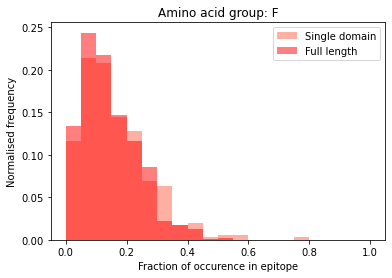

ztest result: (-1.6775271417396833, 0.09343944655234945)
DABEST v0.3.1
             
Good afternoon!
The current time is Thu Jun  9 14:40:38 2022.

The unpaired mean difference between Single domain and Full length is 0.00254 [95%CI -0.0118, 0.0172].
The p-value of the two-sided permutation t-test is 0.74. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


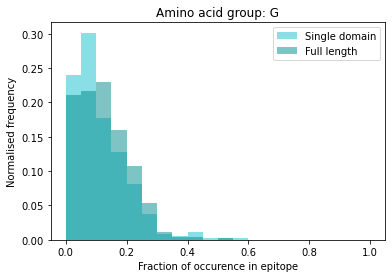

<IPython.core.display.Javascript object>

In [ ]:
#Plot difference decomposition between single domain and full length per amino acid group 
plot_epitope_distribution_difference_per_group(df_frac_occurence_per_aagroup_arp_nb, df_frac_occurence_per_aagroup_arp_fv, "Single domain", "Full length", colour_palette_aa_group, colour_palette_aa_group_2)
